In [1]:
# Imports and Data Loading

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from keras.datasets import mnist


In [3]:
# Load MNIST data from Keras and normalize to [0, 1]
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X.astype(np.float32) / 255.0
test_X = test_X.astype(np.float32) / 255.0


In [4]:
# Dataset Class and DataLoader Setup

class MNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx]).unsqueeze(0)  # (1, 28, 28)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Normalize grayscale images to [-1, 1]
transform = transforms.Normalize((0.5,), (0.5,))

# Create dataset and loaders
train_dataset = MNISTDataset(train_X, train_y, transform=transform)
test_dataset = MNISTDataset(test_X, test_y, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [5]:
# Normalize grayscale images to [-1, 1]
transform = transforms.Normalize((0.5,), (0.5,))

# Create dataset and loaders
train_dataset = MNISTDataset(train_X, train_y, transform=transform)
test_dataset = MNISTDataset(test_X, test_y, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [6]:
# Create dataset and loaders
train_dataset = MNISTDataset(train_X, train_y, transform=transform)
test_dataset = MNISTDataset(test_X, test_y, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [7]:
# CNN Model Definition

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 3 * 3)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [8]:
# Model Setup and Evaluation Function

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [9]:
# Accuracy and F1 on given loader
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds) * 100
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return acc, f1


In [11]:
# Training Loop (5 Epochs)

from collections import deque

num_epochs = 5
losses, train_acc_list, test_acc_list, iterations = [], [], [], []
loss_window = deque(maxlen=10)  # for smoothed loss

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    train_preds, train_labels = [], []

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_window.append(loss.item())
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_preds.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

        if (i+1) % 10 == 0:
            smoothed_loss = sum(loss_window) / len(loss_window)
            losses.append(smoothed_loss)
            iterations.append(len(iterations) + 1)

    scheduler.step()
    avg_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_f1 = f1_score(train_labels, train_preds, average='weighted')
    test_acc, test_f1 = evaluate(model, test_loader)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    print(f"Epoch {epoch+1}/5 | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Train F1: {train_f1:.4f} | Test Acc: {test_acc:.2f}% | Test F1: {test_f1:.4f}")


Epoch 1/5 | Loss: 0.0256 | Train Acc: 99.23% | Train F1: 0.9923 | Test Acc: 99.30% | Test F1: 0.9930
Epoch 2/5 | Loss: 0.0226 | Train Acc: 99.33% | Train F1: 0.9933 | Test Acc: 99.30% | Test F1: 0.9930
Epoch 3/5 | Loss: 0.0198 | Train Acc: 99.41% | Train F1: 0.9941 | Test Acc: 99.24% | Test F1: 0.9924
Epoch 4/5 | Loss: 0.0179 | Train Acc: 99.45% | Train F1: 0.9945 | Test Acc: 99.39% | Test F1: 0.9939
Epoch 5/5 | Loss: 0.0169 | Train Acc: 99.48% | Train F1: 0.9948 | Test Acc: 99.43% | Test F1: 0.9943


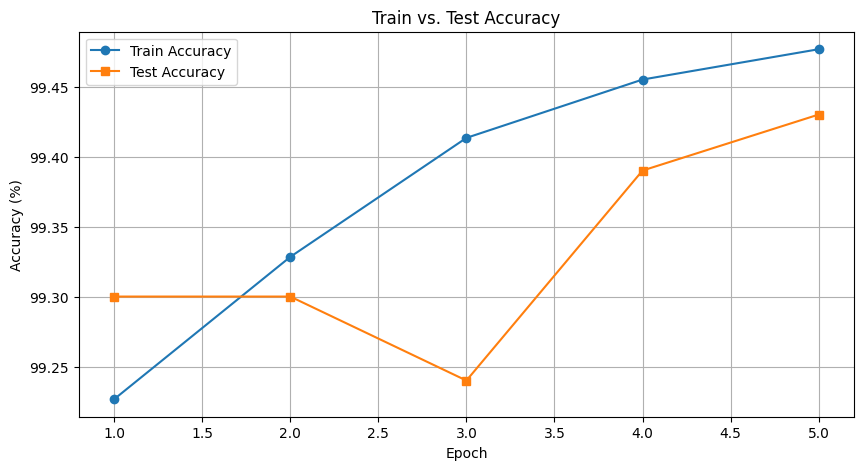

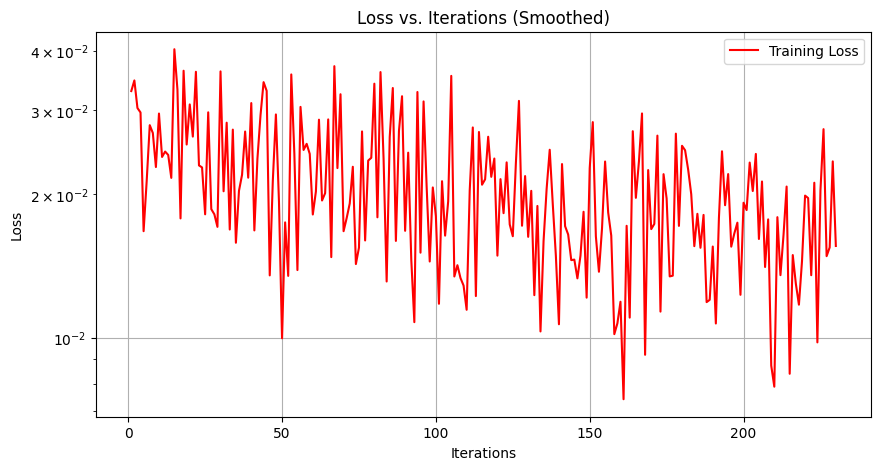

In [12]:
# Plot Accuracy and Smoothed Loss Curve

plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs + 1), train_acc_list, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs + 1), test_acc_list, label="Test Accuracy", marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs. Test Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(iterations, losses, label="Training Loss", color='red')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations (Smoothed)')
plt.legend()
plt.grid()
plt.yscale('log')
plt.show()


In [13]:
# Display Sample Test Predictions

model.eval()
sample_images, sample_labels, sample_preds = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        if len(sample_images) < 10:
            needed = 10 - len(sample_images)
            sample_images.extend(images[:needed].cpu().numpy())
            sample_labels.extend(labels[:needed].cpu().numpy())
            sample_preds.extend(predicted[:needed].cpu().numpy())



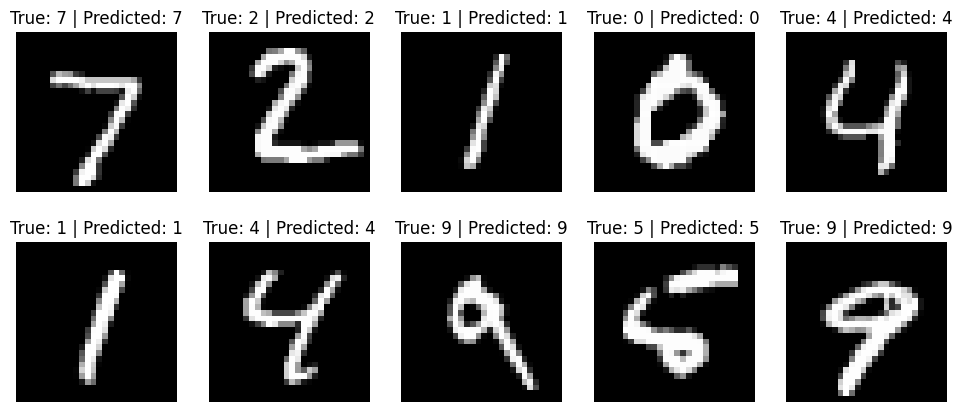

In [16]:
# Show 10 sample predictions
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img = sample_images[i][0] * 0.5 + 0.5
    ax.imshow(img, cmap='gray')
    ax.set_title(f"True: {sample_labels[i]} | Predicted: {sample_preds[i]}")
    ax.axis("off")
plt.show()